# Exploring precision and recall

- Use Amazon review data in its entirety.
- Train a logistic regression model.
- Explore various evaluation metrics: accuracy, confusion matrix, precision, recall.
- Explore how various metrics can be combined to produce a cost of making an error.
- Explore precision and recall curves.

In [1]:
import numpy as np
import pandas as pd
from __future__ import division
import string
import json

Load Amazon dataset

In [2]:
products = pd.read_csv('amazon_baby.csv')

Perform text cleaning

In [3]:
def remove_punctuation(text):
    return text.translate(None, string.punctuation)

products['review_clean'] = products['review'].apply(lambda x: remove_punctuation(str(x)))

Extract Sentiments

In [4]:
products = products[products.rating != 3]

In [5]:
products['sentiment'] = products.rating.apply(lambda x: +1 if (x > 3) else -1)

Split into training and test sets

In [6]:
with open('module-9-assignment-train-idx.json') as train_idx_file:
    train_idx = json.load(train_idx_file)
train_data = products.iloc[train_idx]

In [7]:
with open('module-9-assignment-test-idx.json') as test_idx_file:
    test_idx = json.load(test_idx_file)
test_data = products.iloc[test_idx]

Build the word count vector for each review

In [8]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(token_pattern=r'\b\w+\b')
train_matrix = vectorizer.fit_transform(train_data['review_clean'])
test_matrix = vectorizer.transform(test_data['review_clean'])

In [9]:
np.shape(train_matrix)

(133416, 121713)

In [10]:
np.shape(test_matrix)

(33336, 121713)

Train a sentiment classifier with logistic regression

In [11]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression()
log_reg.fit(train_matrix, train_data['sentiment'])

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

Accuracy

# Using accuracy as the evaluation metric, was our logistic regression model better than the baseline (majority class classifier)?

In [12]:
test_pred = log_reg.predict(test_matrix)

In [13]:
test_accuracy = sum(test_pred == test_data['sentiment']) / len(test_data)
print test_accuracy

0.932655387569


In [14]:
from sklearn.metrics import accuracy_score

test_accuracy_sk = accuracy_score(test_data['sentiment'], test_pred)
print test_accuracy_sk

0.932655387569


Baseline: Majority class prediction

In [15]:
maj_class_pred_accuracy = accuracy_score(y_true=test_data['sentiment'], y_pred=np.array([1.0]*len(test_data)))
print maj_class_pred_accuracy

0.842782577394


In [16]:
baseline = len(test_data[test_data['sentiment'] == 1])/len(test_data)
print "Baseline accuracy (majority class classifier): %s" % baseline

Baseline accuracy (majority class classifier): 0.842782577394


Confusion Matrix

Using your tool, print out the confusion matrix for a classifier.

In [17]:
from sklearn.metrics import confusion_matrix

test_data_cm = confusion_matrix(test_data['sentiment'], test_pred)
print test_data_cm

[[ 3806  1435]
 [  810 27285]]


# How many predicted values in the test set are false positives?
from the psuedo code

In [18]:
from sklearn.metrics import confusion_matrix
cmat = confusion_matrix(y_true=test_data['sentiment'],
                        y_pred=test_pred,
                        labels=log_reg.classes_)    # use the same order of class as the LR model.
print ' target_label | predicted_label | count '
print '--------------+-----------------+-------'
# Print out the confusion matrix.
# NOTE: Your tool may arrange entries in a different order. Consult appropriate manuals.
for i, target_label in enumerate(log_reg.classes_):
    for j, predicted_label in enumerate(log_reg.classes_):
        print '{0:^13} | {1:^15} | {2:5d}'.format(target_label, predicted_label, cmat[i,j])

 target_label | predicted_label | count 
--------------+-----------------+-------
     -1       |       -1        |  3806
     -1       |        1        |  1435
      1       |       -1        |   810
      1       |        1        | 27285


- 100 for each false positive
- 1 for each false negative
- Correctly classified reviews incur no cost

# Given the stipulation, what is the cost associated with the logistic regression classifier's performance on the test set?

In [19]:
print (100*1435 + 1*810)

144310


Precision and Recall

# Out of all reviews in the test set that are predicted to be positive, what fraction of them are false positives?

In [20]:
precision = test_data_cm[1,1] / (test_data_cm[0,1] + test_data_cm[1,1])
recall = test_data_cm[1,1] / (test_data_cm[1,0] + test_data_cm[1,1])
print "Precision:", precision
print "Recall:", recall

Precision: 0.950034818942
Recall: 0.971169247197


In [21]:
from sklearn.metrics import precision_score

precision2 = precision_score(test_data['sentiment'], test_pred)
print "False positives:", (1-precision2)

False positives: 0.0499651810585


# What fraction of the positive reviews in the test_set were correctly predicted as positive by the classifier?

In [22]:
from sklearn.metrics import recall_score

recall2 = recall_score(test_data['sentiment'], test_pred)
print "Recall:", recall2

Recall: 0.971169247197


# What is the recall value for a classifier that predicts +1 for all data points in the test_data?

In [23]:
print recall_score(test_data['sentiment'], np.array([1]*len(test_data)))

1.0


Precision-recall tradeoff

In [24]:
def apply_threshold(probabilities, threshold):
    pred = []
    for i in xrange(len(probabilities)):
        pred.append(+1 if (probabilities[i] > threshold) else -1)
    return pred

In [25]:
model_prob = log_reg.predict_proba(test_matrix)[:,1]
pred_05 = apply_threshold(model_prob, 0.5)
pred_09 = apply_threshold(model_prob, 0.9)

By changing the probability threshold, it is possible to influence precision and recall. Compute precision and recall for threshold values 0.5 and 0.9.

In [26]:
precision_05 = precision_score(test_data['sentiment'], pred_05)
recall_05 = recall_score(test_data['sentiment'], pred_05)
precision_09 = precision_score(test_data['sentiment'], pred_09)
recall_09 = recall_score(test_data['sentiment'], pred_09)
print "Precision and Recall 0.5 threshold", precision_05, recall_05
print "Precision and Recall 0.9 threshold", precision_09, recall_09

Precision and Recall 0.5 threshold 0.950034818942 0.971169247197
Precision and Recall 0.9 threshold 0.981506630452 0.87463961559


Precision-recall curve

In [27]:
thresholds = np.linspace(0.5, 1, 100)
precision_all = []
recall_all = []

for i in xrange(len(thresholds)-1):
    pred = apply_threshold(model_prob, thresholds[i])
    precision_all.append(precision_score(test_data['sentiment'], pred))
    recall_all.append(recall_score(test_data['sentiment'], pred))

In [28]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot_pr_curve(precision, recall, title):
    plt.rcParams['figure.figsize'] = 7, 5
    plt.locator_params(axis = 'x', nbins = 5)
    plt.plot(precision, recall, 'b-', linewidth=4.0, color = '#B0017F')
    plt.title(title)
    plt.xlabel('Precision')
    plt.ylabel('Recall')
    plt.rcParams.update({'font.size': 16})

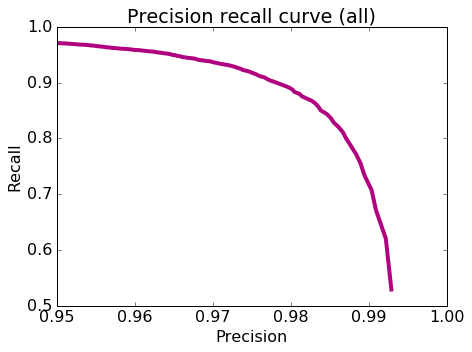

In [29]:
plot_pr_curve(precision_all, recall_all, 'Precision recall curve (all)')

# Among all the threshold values tried, what is the smallest threshold value that achieves a precision of 96.5% or better? Round your answer to 3 decimal places.

In [30]:
i = [i for i, p in enumerate(precision_all) if p >= .965][0]
round(thresholds[i], 3)

0.707

# Using threshold = 0.98, how many false negatives do we get on the test_data? This is the number of false negatives (i.e the number of reviews to look at when not needed) that we have to deal with using this classifier.

In [31]:
pred_098 = apply_threshold(model_prob, 0.98)
cm_098 = confusion_matrix(test_data['sentiment'], pred_098)
print cm_098

[[ 5047   194]
 [ 8268 19827]]


In [32]:
cm_098[1,0]

8268

Evaluating specific search terms

Precision-Recall on all baby related item

In [33]:
test_data2 = test_data.dropna()
baby_reviews = test_data2[test_data2['name'].str.lower().str.contains('baby')]

In [34]:
baby_matrix = vectorizer.transform(baby_reviews['review_clean'])
baby_prob = log_reg.predict_proba(baby_matrix)[:,1]

In [35]:
threshold_values = np.linspace(0.5, 1, 100)
precision_baby = []
recall_baby = []

for i in xrange(len(threshold_values)-1):
    pred = apply_threshold(baby_prob, threshold_values[i])
    precision_baby.append(precision_score(baby_reviews['sentiment'], pred))
    recall_baby.append(recall_score(baby_reviews['sentiment'], pred))

# Among all the threshold values tried, what is the smallest threshold value that achieves a precision of 96.5% or better for the reviews of data in baby_reviews? Round your answer to 3 decimal places.

# Is this threshold value smaller or larger than the threshold used for the entire dataset to achieve the same specified precision of 96.5%?

In [36]:
i = [i for i,p in enumerate(precision_baby) if(p >= 0.965)][0]
round(threshold_values[i], 3)

0.722

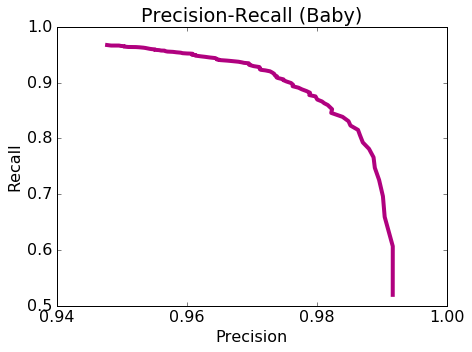

In [37]:
plot_pr_curve(precision_baby, recall_baby, "Precision-Recall (Baby)")